# Our Product: A Movie Expert

You are asked to write a chatbot to help users with choosing a movie to watch. It's a simple task, after all. You know that LLMs can store factual informations, but to have more reliable answers and up-to-date information, you choose to implement a pattern named Retrieval Augmented Generation (RAG). The term was coined in a famous paper from 2020 [(arXiv:2005.11401)](https://arxiv.org/abs/2005.11401) - at the time, ChatGPT wasn't even released, though we already had models like GPT-3 ([arXiv:2005.14165](https://arxiv.org/abs/2005.14165)) to play around with. (GPT-3 weights weren't, and still aren't, released.)

After less than a week of work, we finalised our proof-of-concept (PoC). Et voilà: here's a robotic movie expert ready to go in production and reply to all cinema geeks' questions! Let's briefly review the code implementation.

In [ ]:
# install some code utilities
import importlib

if not importlib.util.find_spec("beyond-the-hype"):
    !pip install -qqq git+https://github.com/xtreamsrl/beyond-the-hype

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "..."

Let's start by the knowledge base. Embeddings have already been created, using `MiniLM`. If you need a refresher, you can find a brief explanation about what an embedding is and what vector databases in the first notebook. You can open it in Colab with this link: [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xtreamsrl/movies-buddy/blob/main/notebooks/00-dataset_builder.ipynb).

In [ ]:
from beyond_the_hype.data import get_movies_dataset

movies = get_movies_dataset()

In [ ]:
movies.head()

To perform a semantic search, we *must* encode the query with the same model used for embedding the context.

In [ ]:
from sentence_transformers import SentenceTransformer

encoder = SentenceTransformer("all-MiniLM-L6-v2")

We use lanceDB, an in-memory vector storage, to store our movies and vectors and build a function to retrieve movies given a user query.

In [ ]:
import lancedb

uri = "./movies_embeddings"
db = lancedb.connect(uri)

movies_table = db.create_table("movies", movies, mode="overwrite")

To keep things simple, we wrap the code to perform the query embedding and search in a function.

In [ ]:
def get_records(query, *, encoder=encoder, db_table=movies_table, max_results=10):
    query_vector = encoder.encode(query).tolist()
    return (
        db_table.search(query_vector)
        .limit(max_results)
        .select(
            [
                "release_year",
                "title",
                "origin",
                "director",
                "cast",
                "genre",
                "plot",
            ]
        )
        .to_list()
    )

Let's see how it works.

In [ ]:
question = "What should I see tonight? I love Sci-Fi movies but I have seen most of the classics, such as Star Wars."

results = get_records(question, max_results=3)

results

This is the R part in RAG: let's take care of the G, shall we?

In the following cells we construct the system message and the prompt of our movie expert. Of course, the prompt must include the movies retrieved by the vector store as context for the LLM.

In [ ]:
GEEK_SYSTEM = """
  You are a DVD record store assistant and your goal is to recommed the user with a good movie to watch.

  You are a movie expert and a real geek: you love sci-fi movies and tend to get excited when you talk about them.
  Nevertheless, no matter what, you always want to make your customers happy.
"""

In [ ]:
prompt_template = """
  Here are some suggested movies (ranked by relevance) to help you with your choice.
  {context}

  Use these suggestions to answer this question:
  {question}
"""

context_template = """
Title: {title}
Release date: {release_year}
Director: {director}
Cast: {cast}
Genre: {genre}
Overview: {plot}
"""


def format_records_into_context(records, *, template):
    return "".join(
        context_template.format(
            title=rec["title"],
            release_year=rec["release_year"],
            director=rec["director"],
            cast=rec["cast"],
            genre=rec["genre"],
            plot=rec["plot"],
        )
        for rec in results
    )

Everything ready to ask a LLM to reply the user questions! 

In [ ]:
import openai

client = openai.OpenAI()


def ask(
    question,
    *,
    max_results=10,
    system=GEEK_SYSTEM,
    prompt_template=prompt_template,
    context_template=context_template,
    db_table=movies_table,
    verbose=False,
):
    records = get_records(
        query=question,
        max_results=max_results,
        db_table=movies_table,
    )
    context = format_records_into_context(records, template=context_template)

    prompt = prompt_template.format(question=question, context=context)

    chat_completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": prompt},
        ],
    )

    answer = chat_completion
    if verbose:
        print(
            answer.choices[0].message.content,
            "=== CONTEXT ===",
            context,
        )

    return answer


answer = ask(question=question, verbose=False)

In [ ]:
print(answer.choices[0].message.content)

The function `ask` is our product. Yes, we could wrap in in a API using a framework like [FastAPI](https://duckduckgo.com/?q=fastapi&ia=web), or chat interface with [Chainlit](https://docs.chainlit.io/get-started/overview). But let's keep things simple.

There is something else that matters - something more pressing: **is this reply good?** Well, it looks good. It replies in a funny tone and suggests a movie! Maybe it's too long... or too short?

Here's the true goal of the workshop, and what we will do next.

Until the break, we'll go over the second and third notebook of the series. We will introduce *subject matter experts* (SME) and how we can leverage their knowledge to shape the product and evaluate it. We'll involve the SME to **"bootstrap" an evaluation dataset**, and use their comments and critiques to build a LLM that **reflects their preferences** and will help us with **evaluating the interactions at scale**. This pattern is known in the literature as "LLM-as-a-judge" [(arXiv:2306.05685)](https://arxiv.org/abs/2306.05685). For the implementation, we'll follow [this excellent article](https://hamel.dev/blog/posts/llm-judge/) by Hamel Husain, who's an independent AI consultant and a part time researcher at Answer.AI, a lab directed by Jeremy Howard.

In the second part, we'll implement two pattenrs to enhance our RAG chatbot: Hypothetical Document Extraction (HyDE) [(arXiv:2212.10496)](https://arxiv.org/abs/2212.10496) and metadata extraction/filtering to make our queries more precise. While not fancy, these will be the first tools you'll likely use to improve your RAG application (outside chunking).

Here is some stuff we won't cover:

1. Chunking.
2. Evaluating the retrieval. Within a RAG system, you evaluate two parts: the retrieval, and the style. Our workshop will focus on style evals, as they are the more subjective and expensive to run (since they require involving stakeholders).

For some more references about evals, you might want to take a look at these excellent blog posts:

1. [The RAG playbook](https://jxnl.co/writing/2024/08/19/rag-flywheel/)
2. [How to build a terrible RAG system](https://jxnl.co/writing/2024/01/07/inverted-thinking-rag/)

Keep this page open: we'll come back to the last section of the notebook later.

It's time to move to the second notebook: [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xtreamsrl/beyond-the-hype/blob/main/notebooks/02-domain-expert.ipynb)

# Let's Run Our First Evaluation Questions

Welcome back! **The output of the second notebook should be a csv file. Download it, then upload it** via the sidebar.

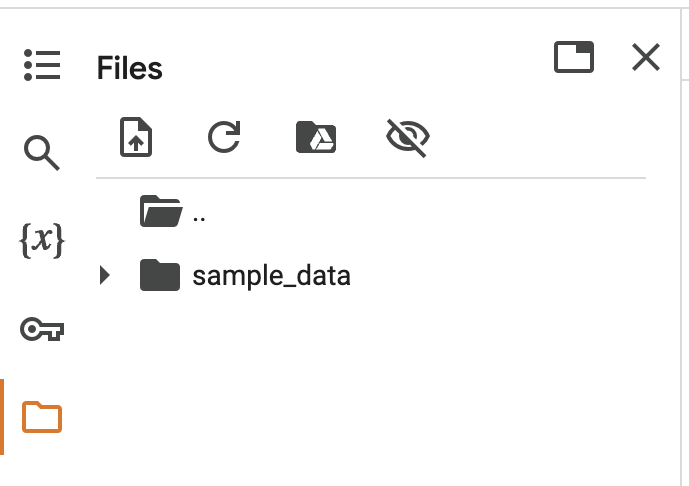

Now we only need to get ready to run the evals! Evals should be run often - though they might not be as fast as a unit test suite.

In [ ]:
import polars as pl

# configure polars to display more text in each row
PL_STR_LEN = 1000
_ = pl.Config.set_fmt_str_lengths(PL_STR_LEN)
_ = pl.Config.set_tbl_width_chars(PL_STR_LEN)

# you might want to change this if you saved the file with a different name
evals_path = "./eval.csv"

eval_dataset = pl.read_csv(evals_path)
eval_dataset

Now that we have ten syntehtic questions, we can have the system answer them.

In [ ]:
from beyond_the_hype.judge import answer_multiple_questions

questions_with_replies = answer_multiple_questions(eval_dataset, ask)

In [ ]:
questions_with_replies

Cool! Our movie expert replies to all the questions in our dataset; our work here is done! But... let's see what our **movie expert** would say about it.

He's not accustomed to `polars`, so let's prepare a more convenient format for them.

In [ ]:
questions_with_replies.write_csv("./eval_replies.csv")

### 🏋️ Exercise: Let the expert evaluate the model answers

One of the most important skills of a data scientist and an AI engineer is to simply *look at the data*. You might not like Excel files (you don't have to), but if they keep you close to the data, then go for them!

1. Download the CSV file and open it in Google Sheets, or Microsoft Excel.
2. Create two new columns: `pass_or_fail` and `comment`.
3. Take some time to read the answers, and ask your SME to either mark them as `pass` or `fail`. Then, add a short comment of the answer: why it's good, or while it isn't.

Why do we use `pass` and `fail`? Why so categorical and not nuanced, like a scale from 1 to 5? We first like binary metrics because they *make the result actionable*: if the rank is a 4, what kind of improvement do we wish to see? Also, they force the evaluator to focus on what matters, and articulate a compelling critique.

In [ ]:
domain_expert_critiques = pl.read_csv(source="./eval_comments.csv")

In [ ]:
domain_expert_critiques.select(
    pl.col("pass_or_fail").value_counts(sort=True, name="count")
).unnest("pass_or_fail")

There are a lot of failures (80%), so let's eye-balling the critiques from the domain expert and cluster them in groups. Possible groups could be:
- missing context: frequently, domain experts said that the model replied saying that it doesn't have the movie in the list
- The system always gives the same suggestion ("Welcome to the Space Show")
- It doesn't manage corner cases, such as unrelated or toxic questions

## The "Easiest First" Rule
Don't panic! You don't need to rebuild all your RAG. Let's keep things simple before discussing complex considerations about restructuring your RAG architecture.

The easiest things to look at are prompts and system messages:


In [ ]:
print(GEEK_SYSTEM)

In [ ]:
print(prompt_template)

Let's quickly iterate through our system message to check if we could have a better response.

In [ ]:
SYSTEM_MESSAGE = """ You are a movie expert, and your goal is to recommend the user with a good movie to watch.

RULES: 
- You should reply to questions about: movies plots or synopsys, movies metadata (release date, cast, or director), provide plots summary;
- For every questions outside the scope please reply politely that you're not able to provide a response and describe briefly your scope;
- Don't mention that you have a list of films as a context. This should be transparent to the user
- If you don't have the movie in your context reply that you don't know how to reply"""

In [ ]:
# todo replace with func
eval_dataset = eval_dataset.with_columns(
    pl.col("question")
    .map_elements(
        lambda question: ask(question, system=SYSTEM_MESSAGE)
        .choices[0]
        .message.content,
        return_dtype=pl.String,
    )
    .alias("rag_answer")
)

In [ ]:
eval_dataset